# **Predictive modelling and identification of key risk factors for stroke using machine learning**


#**1. Problem Definition and Data Preparation**

## **Introduction**
Stroke is one of the leading causes of death and disability worldwide. It occurs when the blood supply to a part of the brain is interrupted or reduced, preventing brain tissues from getting oxygen and nutrients. Early prediction and prevention strategies, although complex and challenging, are crucial to reduce stroke incidence and improve patient outcomes.

###**Objective of the project**
The goal of this project is to analyze the **Stroke Prediction Dataset** from Kaggle and build machine learning models that predict whether a patient is likely to experience a stroke, based on diagnostic features such as gender, age, medical history and lifestyle.

Additionally, we aim to:
- Understand what are the significant contributors to strokes
- Suggest potential prevention measures based on feature importance analysis

**Dataset source**

[Kaggle- Stroke Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/data)

-------------------------------------------------------------------------------

### **Assumptions and Simplifications**

- The accuracy and reliability of the dataset are **not guaranteed**; therefore, data validation is necessary

- Missing values will be addressed through imputation methods detailed later in this project

- The `children` category under work type is assumed to represent patients below the legal working age

- We define 16 as the minimum legal working age and assume no underage patients were employed illegally  

- A retirement age of 65 is assumed for both male and female patients

- A smoking status of `Unknown` indicates **missing** or **uncollected information** for that individual

- The dataset is assumed to represent a general, diverse patient population

- The prediction task is simplified to a binary classification: stroke (1) vs. no stroke (0)

### **Medical Metrics**

Understanding the medical context is crucial when analyzing clinical datasets. Below are two important health indicators:

**Blood Glucose Levels**

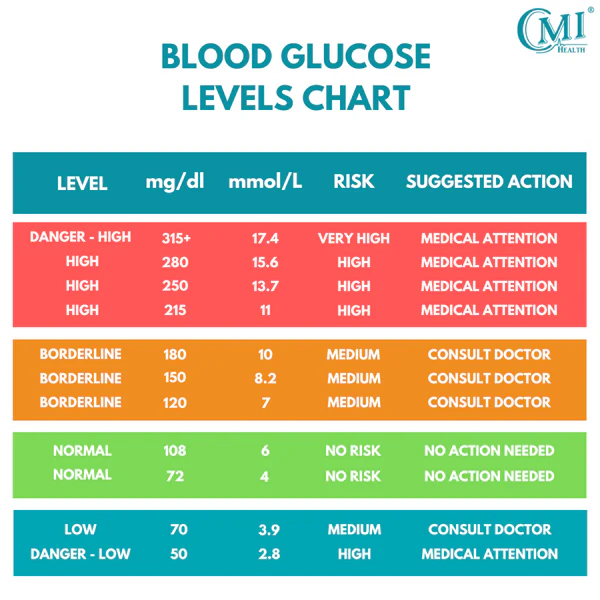

**Disclaimer:**

The blood glucose levels presented refer to fasting blood glucose tests, meaning measurements taken after the patient has not eaten or drunk (except water) for at least 8 hours. Non-fasting levels can differ significantly.

**Body Mass Index (BMI)**

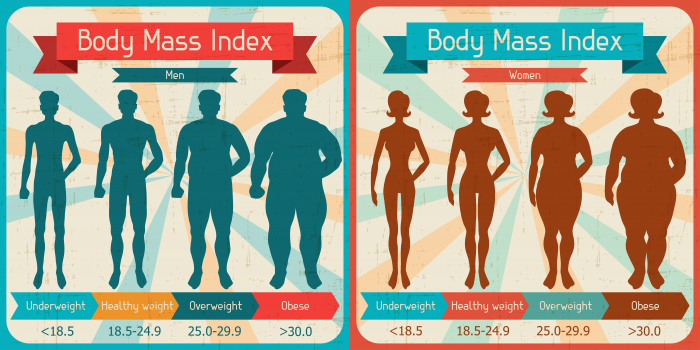

**Note:**
 BMI is calculated the same way for both males and females. However, its interpretation may differ slightly, as females typically have a higher body fat percentage than males at the same BMI. For the purposes of this project, we treat BMI ranges uniformly across both sexes.

## **Understanding the Dataset**

The dataset contains **5110 patient records** and **12 features**, divided into:
- **Target Variable:** `stroke` (1 if stroke occurred, 0 otherwise)
- **Demographics:** gender, age, marital status, work type, residence type
- **Medical history:** hypertension, heart disease, average glucose level, BMI
- **Lifestyle:** smoking status  

### **Libraries**

In [3]:
# Dataset + visualizations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Training of the model + Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             precision_recall_curve, roc_auc_score)
from sklearn.tree import plot_tree

### **Importing the dataset**

In [4]:
df = pd.read_csv('/content/drive/MyDrive/kaggle/healthcare-dataset-stroke-data.csv')

### **Exploration of the data**

In this stage we will:

- Analyze the dataset and explore **feature distributions**, as well as detect potential anomalies

- Check for duplicates

- Check for missing values

- Address **noisy** or **outlier data** for better quality data

#### **Structure of the dataset**

In [43]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,29.3,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


#### **Datatypes of each feature**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


#### **Duplicate rows/Missing values**

In [7]:
print(f"Number of duplicate rows: {df.duplicated().sum()}\n")

Number of duplicate rows: 0



In [8]:
print("Number of missing values per feature:")
df.isnull().sum()

Number of missing values per feature:


,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,201


#### **Feature values and counts**

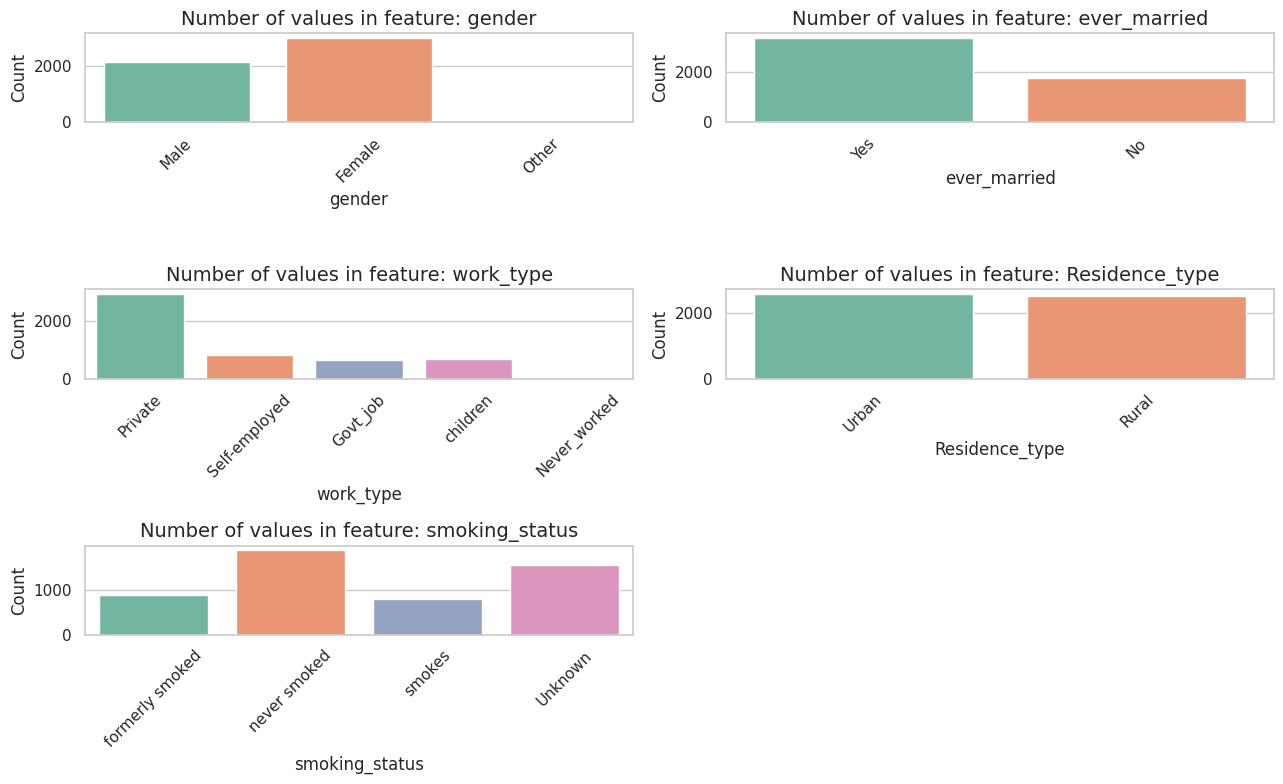

In [9]:
categorical_features = ['gender','ever_married','work_type','Residence_type','smoking_status']
sns.set(style="whitegrid")

fig,axes = plt.subplots(nrows=3, ncols=2, figsize=(13,8))
axes = axes.flatten() # flattening 2D array to 1D for easier looping

for i, feature in enumerate(categorical_features):
  sns.countplot(data=df, x=feature, hue=feature, ax=axes[i], palette="Set2", legend=False)
  axes[i].set_title(f'Number of values in feature: {feature}', fontsize=14)
  axes[i].set_ylabel('Count')
  axes[i].set_xlabel(feature)
  axes[i].tick_params(axis='x', rotation=45)

for j in range(len(categorical_features), len(axes)):
  fig.delaxes(axes[j]) # To leave out subplots that are not being used in the grid

plt.tight_layout()
plt.show()

#### **Stroke incidence**

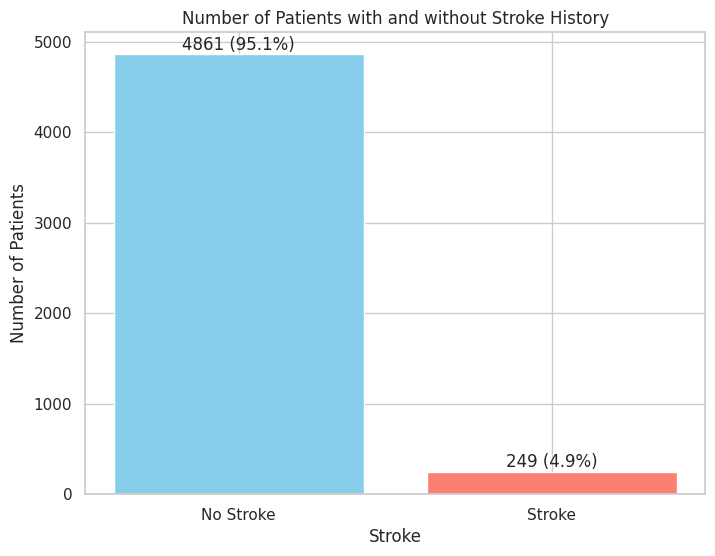

In [10]:
stroke_counts = df['stroke'].value_counts()
stroke_percentages = stroke_counts / len(df) * 100

# Create the bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(stroke_counts.index, stroke_counts.values, color=['skyblue', 'salmon'])

# Add percentage labels on top of the bars
for i, bar in enumerate(bars):
  xval = bar.get_x() + bar.get_width()/2
  yval = bar.get_height()
  count = stroke_counts[i]
  percentage = stroke_percentages[i]
  plt.text(xval, yval + 5, f'{count} ({percentage:.1f}%)', ha='center', va='bottom')

# Customize the plot
plt.xlabel('Stroke')
plt.ylabel('Number of Patients')
plt.title('Number of Patients with and without Stroke History')
plt.xticks(stroke_counts.index, ['No Stroke', 'Stroke'])
plt.show()

#### **Feature Statistics**

In [11]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


### **Initial Observations**
- **Data Quality:**
  - No duplicated rows were found
  
  - There are 201 missing BMI values in patients

  - There are some redundant values in certain categorical features (`Other` and `Never_worked`)

- **Class Imbalance:**
  - Only ~5% of patients had a stroke, which indicates a **major imbalance** between patients who had stroke and who didn't

- **Feature Statistics**:
  - **Mean age:** ~43 years (oldest: 82)

  - **Mean glucose level:** ~106 mg/dL (normal fasting glucose), the maximum recorded (271.74) indicates a very poorly controlled diabetes, yet it is absolutely possible in real patients

  - **Mean BMI:** ~28.9 (overweight category), the maximum BMI recorded (97.6) indicates an extreme outlier that requires further investigation

  - Both the `avg_glucose_level` and `bmi` features show relatively high standard deviations, which suggests a wide variability in patient health conditions:
    - It may reflect the presence of patients with severe metabolic or cardiovascular issues.
    
    - Alternatively, it could point toward possible data entry errors or outliers that need to be carefully assessed and addressed

## **Knowledge Discovery Process (KDD)**

In this section we will present the KDD steps for the stroke prediction problem:

1. **Domain Understanding and Goal Definition:**

  The initial step includes understanding the problem and defining the goals of the knowledge discovery process.

  - Objectives:
      - **Predict** whether a new patient will experience a stroke or not
      - **Identify** the leading risk factors
      - **Suggest**  prevention measures

2. **Data collection and Selection:**

  At this stage, relevant data is collected from various sources or selected from available datasets based on the defined goals and requirements.

  - We use the **Stroke Prediction dataset** which is made out of 5110 records, each record containing 12 attributes

  - For the time being, we will use all the features, as they are all potentially important for the dataset analysis

  - Later on in the data cleaning process, we will leave out the `id` feature as it won't contribute to our understanding of stroke occurrence, it only helps identify the patients        

3. **Data Cleaning and Preprocessing:**

  Before analysis can begin, the selected data must be cleaned and preprocessed to ensure its quality and suitability for analysis. This includes handling missing values, removing noise, dealing with outliers, and converting the data into an appropriate format.

  What we have already found:

  - **Duplicates:** none

  - **Missing values/Outliers:** 201 BMI values are missing + suspicious BMI values were found

  - These values will be imputed with a **group median** based on `ever_married` and `hypertension` features, we will explain how and why we are going to do that in the next sections


4. **Data Transformation:**

  In this stage, the preprocessed data may undergo various transformations to make it suitable for mining - such as normalization, discretization, dimensionality reduction, to simplify the data while preserving its essential information.

  The data transformation we need to do:

  - Split features into **numerical features** and **categorical features**:

    - Use `StandardScaler` to standardize the numerical features, which helps in dealing with model sensitivity to scale and stable convergence

    - Use `OneHotEncoder` to create one-hot-vectors for the categorical features

  - Address the class imbalance by using **SMOTE** oversampling inside the model pipeline, it helps balancing the classes, allowing the model to learn patterns that lead to stroke    

5. **Model Selection:**
  
  We selected two models:
    - **Logistic Regression**, which is linear and has an interpretable baseline

    - **CART with Gini**, which captures non-linear patterns and yields a visual tree that can be analyzed and interpreted

6. **Discretisation and Feature Engineering:**
  
  One-Hot-Encoding automatically discretises categorical values into binary flags. The target `stroke` remains a binary class (0 for no-stroke and 1 for stroke). No extra binning is required

7. **Data Mining (Modelling):**

  That is, applying the selected data mining algorithms (from step 5) to the data in order to extract patterns and trends.

  We will build an imbalanced-learn pipeline in the following steps:
    1. Preprocess the data

    2. Use **SMOTE** oversampling inside the model pipeline

    3. Search hyper-parameters with **GridSearchCV** and **10-fold stratified cross-validation**, which optimizes the **F1-score**

    4. Use the hyper-parameters to train the models

    5. Evaluate results

8. **Interpretation and Evaluation:**

  Once patterns or knowledge are discovered, they must be interpreted and evaluated. This stage includes reviewing the results in the context of the problem domain and verifying their accuracy and relevance. Using the resulting model, we can now evaluate new data records and decide on their predicted value:

  How the interpretation and evaluation will be done:

  - Use **classification reports**, which include **precision**, **recall**, **F1-score** and **accuracy**

    - Due to the imbalanced nature of our dataset, we would place a stronger emphasis on:
    
      - **Recall** for the stroke class (true positive rate), to minimize false negatives, which are more dangerous in a medical context

      - **F1-score**, as it balances precision and recall, especially in imbalanced datasets.

      - **ROC-AUC score**, that measures the model's ability to distinguish between the two classes across all thresholds.
    
  - Discuss model comparison using the evaluation metrics in the classification reports, as well as the interpretability of the features

  - Offer potential improvements and prevention measures

## **Comparative Review of Data Mining Alternatives for Stroke Prediction:**

In this section, we compare four popular data mining approaches that are applicable to the stroke prediction problem:

1. **Logistic Regression**
2. **ID3/ID4**
3. **J48 (C4.5)**
4. **CART (with Gini Index)**

Each model is evaluated in terms of its advantages and disadvantages within the context of our dataset and goal.

| **Model**          | **Description**                                                                                     | **Advantages**                                                                                     | **Disadvantages**                                                                                     |
|------------------------|-----------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------|
| **Logistic Regression** | A linear model estimating the probability of a binary outcome (stroke vs. no stroke)               | - Easy to interpret<br>- Fast to train<br>- Good for linearly separable data                        | - Assumes linearity<br>- May struggle with complex patterns and interactions                          |
| **ID3 / ID4**           | Early decision tree algorithm using **information gain** to split nodes                            | - Simple and fast<br>- Good for categorical data<br>- Transparent logic                            | - Cannot handle numeric attributes without discretization<br>- No pruning (risk of overfitting)        |
|**J48** (C4.5)          | An extension of ID3 that builds decision trees with pruning, handles both continuous and discrete data | - Handles missing values<br>- Prunes to avoid overfitting<br>- Interpretable tree structure         | - Can still overfit on small/noisy datasets<br>- Less accurate than ensemble methods in some cases   |
| **CART** (Gini Index)   | Builds binary decision trees using the **Gini impurity** metric                                     | - Naturally supports numeric and categorical data<br>- Robust with Gini as split criterion          | - Only binary splits (can grow to deep trees)<br>- Needs pruning to avoid overfitting                     |

Given the binary classification task and the mix of numeric and categorical features in our dataset:

1. **Logistic Regression** can be valuable for its **interpretability and speed**, serving as a solid baseline

2. **CART with Gini** can be practical for its ability to handle both **numeric and categorical variables directly**

3. **J48** can offer better generalization than ID3 and can work well when pruning is needed

4. **ID3/ID4** is less commonly used due to the lack of pruning and numeric support


For robust results, a comparison of all models can be conducted using **cross-validation** and **oversampling (SMOTE)**.

##1.(e) **Preprocessing and Cleaning stage**


### **BMI outliers**

In [12]:
df[df['bmi'] >= 60] # Check for extremely high BMI values in patients

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
270,72911,Female,57.0,1,0,Yes,Private,Rural,129.54,60.9,smokes,0
358,66333,Male,52.0,0,0,Yes,Self-employed,Urban,78.40,64.8,never smoked,0
466,1307,Female,61.0,1,0,Yes,Private,Rural,170.05,60.2,smokes,0
544,545,Male,42.0,0,0,Yes,Private,Rural,210.48,71.9,never smoked,0
928,41097,Female,23.0,1,0,No,Private,Urban,70.03,78.0,smokes,0
1559,37759,Female,53.0,0,0,Yes,Private,Rural,72.63,66.8,Unknown,0
2128,56420,Male,17.0,1,0,No,Private,Rural,61.67,97.6,Unknown,0
2764,20292,Female,24.0,0,0,Yes,Private,Urban,85.55,63.3,never smoked,0
2840,65895,Female,52.0,0,0,Yes,Private,Urban,98.27,61.2,Unknown,0
3825,72784,Female,52.0,0,0,Yes,Private,Rural,118.46,61.6,smokes,0


**Reflection**

To ensure the integrity of our analysis, it is essential to reflect on the unusually high BMI values observed in the dataset.

**Why a threshold of BMI ≥ 60?**
- BMIs between **50 and 60** do occur in cases of **extreme clinical obesity**, although they are rare.

- **BMIs exceeding 60** are **extremely rare**, even among patients classified with morbid obesity.

- Therefore, encountering BMIs above 60 strongly suggests a **high probability of data issues** such as:
  - Measurement errors
  
  - Data entry mistakes

  - Exceptionally rare medical cases (which are statistically negligible in general population studies)

**Current situation:**
- We identified **13 patient records** with BMI values ranging from **60.2 to 97.6**

- Some patients also have low glucose levels and no other recorded medical issues, which is **very unlikely** biologically

**What are the options for handling those outlier data points?**

 | Option | Description | Pros | Cons |
|:-------|:------------|:-----|:-----|
| 1. Leave them | Keep all BMI records, even extreme ones | Preserves rare cases if real | Model might learn wrong patterns if data is wrong |
| 2. Remove them | Drop all suspicious BMI records | Cleaner dataset, avoids noise | Loses information, smaller dataset |
| 3. Impute them | Estimate BMI values based on other features | Keeps patient records and reduces noise | Needs careful imputation method |


Given that we only have **5510 samples**, every record counts for training robustness. We will choose **option 3** and impute the BMI outliers in order to optimize model reliability without sacrificing too much data.


There are several ways to do that:
- We can replace BMI with the **mean** or **median BMI** of the **entire dataset** (excluding outliers), it is simple, yet it can ignore patient-specific characteristics that might've been important.

- We can try **group-based mean/median**, by replacing the BMI using the mean/median of patients in the same age/gender/glucose level group. It is a little more advanced, yet it preserves some individual differences from other patients.

- We can build a **regression model** to predict BMI based on the dataset features, this can be very precise, but computationally heavier and more complex.

Let us not forget that we have additional 201 patients that have missing BMI values, that makes 214 BMI records that we have to deal with. Given that fact, it is important to care about preserving realism but also avoiding heavy bias.

Therefore, the best balancing solution would be the **group-based median imputation**.

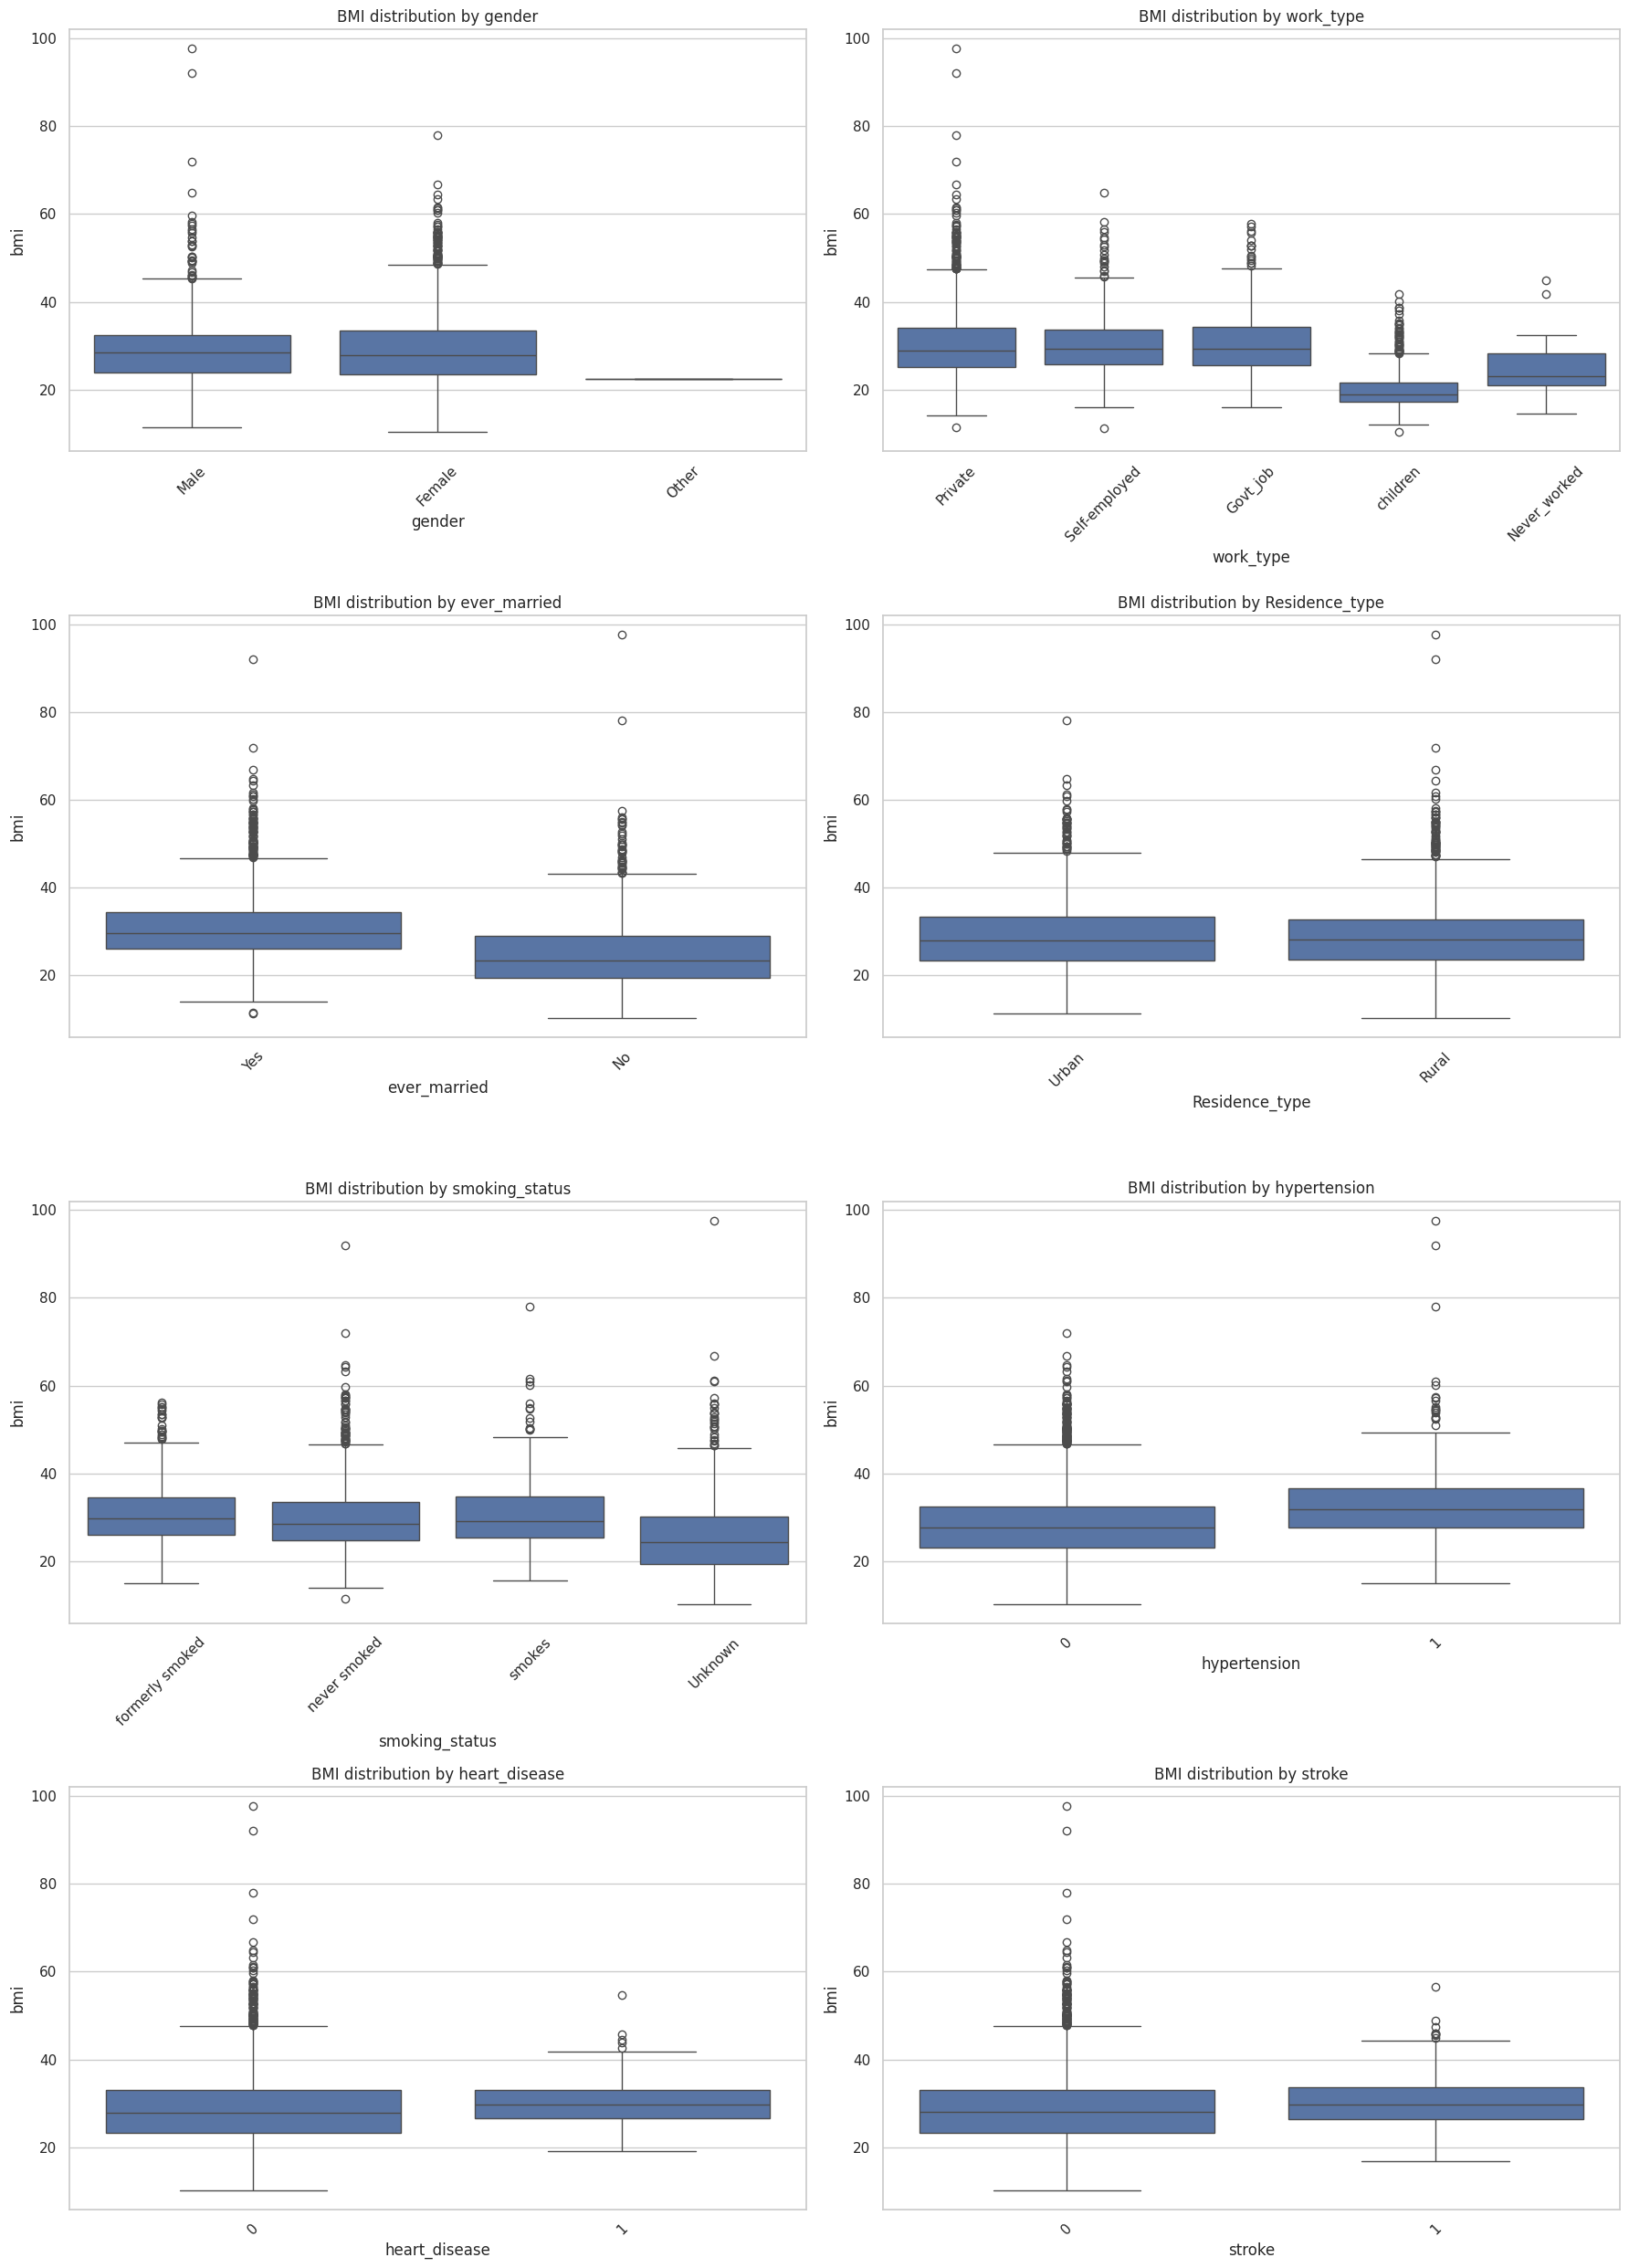

In [13]:
features = ['gender', 'work_type', 'ever_married','Residence_type', 'smoking_status',
                        'hypertension','heart_disease','stroke']
plt.figure(figsize=(18,25))
for idx, feature in enumerate(features):
  plt.subplot(4,2, idx+1) # 4 rows, 2 columns and idx+1 for position
  sns.boxplot(x=feature, y='bmi',data=df)
  plt.title(f'BMI distribution by {feature}')
  plt.xticks(rotation=45)
  plt.tight_layout()

plt.show()

When facing missing and unrealistic BMI values, it is crucial to find a way to **impute BMI as accurately as possible** while preserving data quality and preventing noise.

To decide which features to group by, we systematically explore the relationship between BMI and several categorical features using **boxplots**:
- **Gender:** Showed some difference, but distributions are relatively close
- **Work Type and smoking_status:** these are optional features, yet they still have central tendencies across groups
- **Ever_married:** There is a clear separation - married individuals tended to have slightly higher BMIs
- **Hypertension:** There is a very distinct difference - hypertensive individuals had higher BMI distributions
- **Heart disease**, **Residence_type** and **Stroke**: they have minor differences, they are not as strong as the other options we had so far


Given the strong influence of both: `ever_married` and `hypertension` features, we will use them to group patients based on the combination of these two features. This method will allow BMI imputation that will better respect the biological and lifestyle differences between patient groups:

In [14]:
problematic_bmi = (df['bmi'].isnull())|(df['bmi'] >= 60) # Finding all missing and outlier BMI values among patients
clean_bmi = df[df['bmi'] < 60]
group_medians = clean_bmi.groupby(['ever_married', 'hypertension'])['bmi'].median().reset_index() # Made a grouped median lookup

In [15]:
def median_bmi(row):
  if not pd.isnull(row['bmi']) and row['bmi'] < 60: #BMI is reasonable and doesn't need changing
    return row['bmi']

  # Find the median BMI of people with the same `ever_married` and `hypertension` values
  group = group_medians[(group_medians['ever_married'] == row['ever_married']) &
                        (group_medians['hypertension'] == row['hypertension'])]

  if not group.empty:
    return group['bmi'].values[0] # If there is such group, use the median BMI of the group

  # Otherwise, try by `ever_married` only
  marry_median = clean_bmi[clean_bmi['ever_married'] == row['ever_married']]['bmi'].median()
  if not pd.isnull(marry_median):
    return marry_median

  # If nothing works, just return that global median
  return clean_bmi['bmi'].median()

Now we will apply this function on the dataset to update it and we'll check if all BMI issues were solved:

In [16]:
df['bmi'] = df.apply(median_bmi, axis=1)

In [17]:
print(df['bmi'].isnull().sum())

0


In [18]:
print((df['bmi'] > 60).sum())

0


In [19]:
print("Number of missing values per feature:")
df.isnull().sum()

Number of missing values per feature:


,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,0


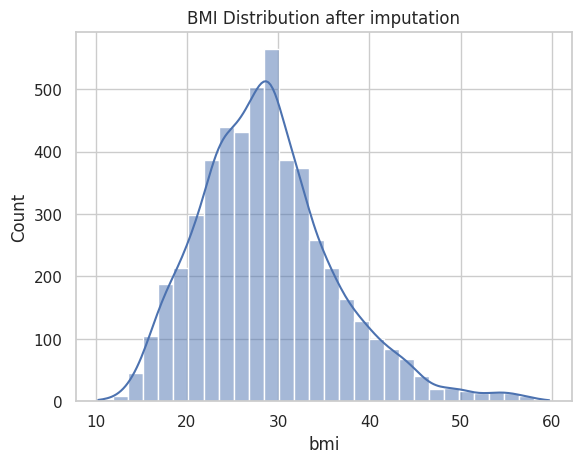

In [20]:
sns.histplot(df['bmi'],kde=True,bins=30)
plt.title('BMI Distribution after imputation')
plt.show()

As we can see, the BMI data looks clean


### **Child and Elderly Labor**

To ensure the integrity of the `work_type` feature, we will perform a logical validation of employment status across different age groups. We will specifically check whether:

- **Children under legal working age** are improperly assigned to working categories

- **Elderly individuals** are misclassified as `Never_worked` or `children`

Currently, the dataset includes a `work_type` category called **"children"**, used for underage individuals. To normalize the dataset we will merge all individuals under the age of 16 into `Never_worked` category since they are not legally eligible for employment.


In [21]:
df[df['work_type'] == 'children']['age'].describe()

,age
count,687.000000
mean,6.841339
std,4.533364
min,0.080000
25%,2.000000
50%,6.000000
75%,11.000000
max,16.000000


In [22]:
legal_age = 16

def reassign_work_type(row):
  if row['age'] < legal_age:
    return 'Never_worked' # In case we are talking about an underaged patient
  elif row['work_type'] == 'children':
    return 'Never_worked' # In case we are talking about a patient whose age is 16+ and is in 'children' work_type
  return row['work_type'] # Otherwise, the patient already is in the legal age for employment and works

df['work_type'] = df.apply(reassign_work_type,axis=1)

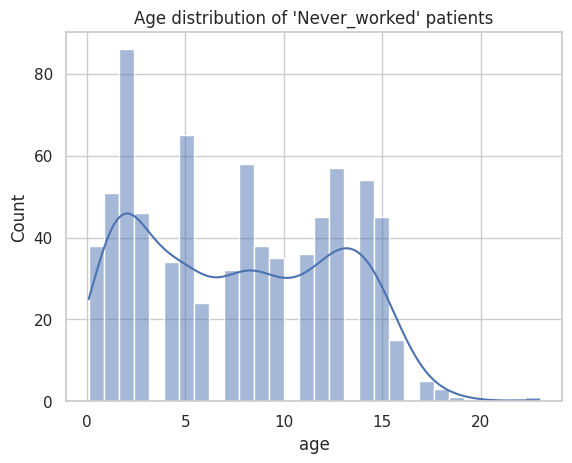

In [23]:
sns.histplot(df[df['work_type'] == 'Never_worked']['age'], bins=30, kde=True)
plt.title("Age distribution of 'Never_worked' patients")
plt.show()

Let us examine whether individuals aged 65 or older are incorrectly categorized, if there will be errors, we will fix them:

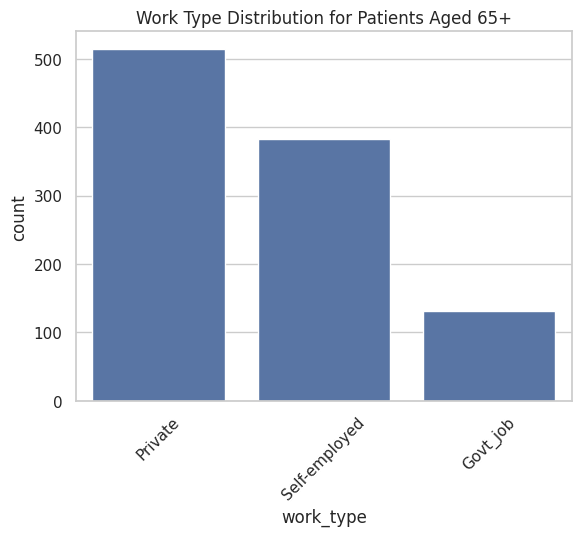

In [24]:
sns.countplot(data=df[df['age'] >= 65], x='work_type')
plt.title('Work Type Distribution for Patients Aged 65+')
plt.xticks(rotation=45)
plt.show()

We can see that no elderly individuals were labeled as `children` or `Never_worked`, we have a separation between underaged patients, elderly patients and patients in the working age.

### **Cleaning redundant values**

In [25]:
print(df['gender'].value_counts())

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64


As we can see, there is only one `Other` entry, our model won't learn anything meaningful from one sample alone and since this entry is rare, it could only cause errors. We will therefore exclude this sample from the dataset

In [26]:
df = df[df['gender'] != 'Other']

We will also drop the ID feature since it is just a unique identifier assigned to each patient, it has no direct influence on whether someone will have a stroke or not and therefore, keeping this feature would only add noise:

In [27]:
df = df.drop(columns=['id'])

### **Correlations**
Let us check whether there are any linear correlations between the features. It is important to do so for several reasons:

- Linear correlations between features can distort the coefficients in models like **Logistic Regression**, making it harder to interpret feature importance or leading to unstable predictions

- Reducing redundant features (in case of high correlation) can simplify the model and speed up the training

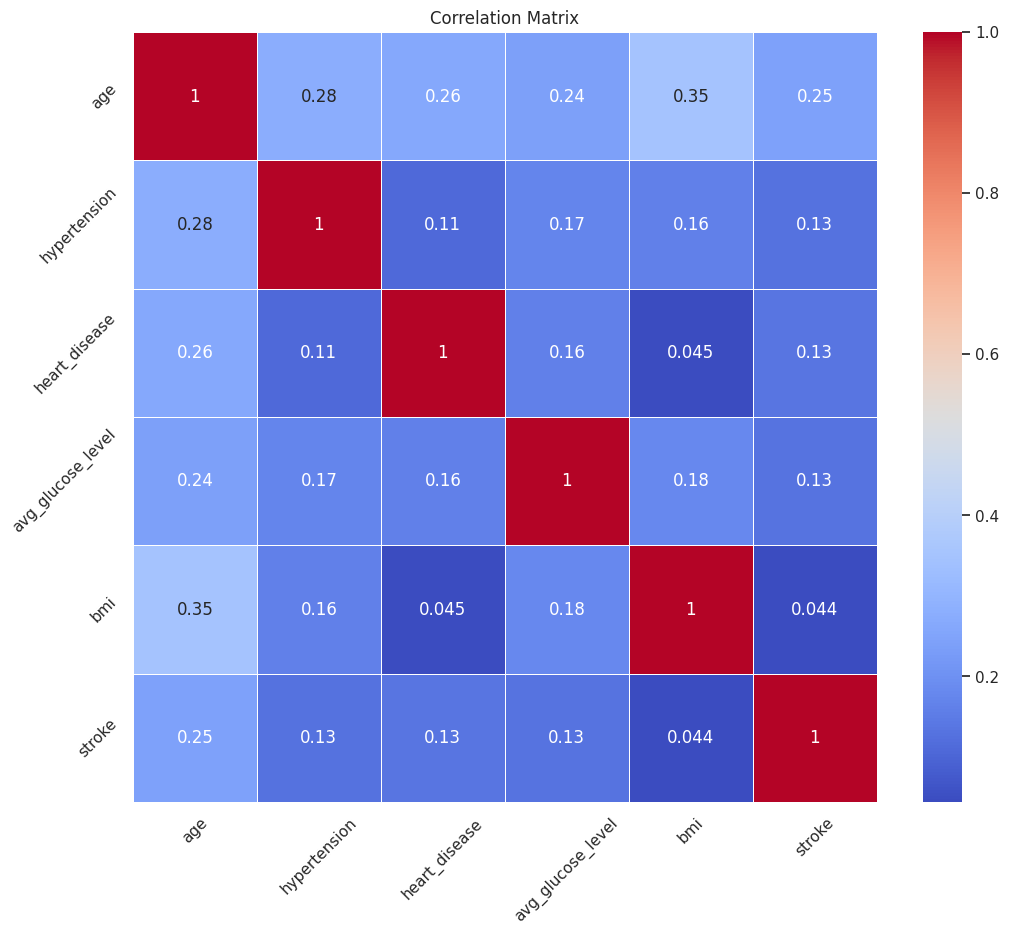

In [28]:
numerical_features = df.select_dtypes(include=['float64','int64'])
corr_matrix = numerical_features.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

We can see that the dataset is healthy in terms of **feature redundancy**, as there are no strong correlations between features. The highest feature correlation found in the correlation matrix is between `age` and `bmi` (~0.35), and it is still considered a **weak to moderate** correlation.

Given this observation, and given the fact that our dataset is already **well-structured**, and has **domain-relevant features** we won't need any advanced feature engineering done for the models we will use

# 2.**Classification**

## **Chosen Classification models**

For our classification task of predicting strokes, we will choose the following two models:

1. **Logistic Regression:** It is a statistical model that is used for binary classification problems. It models the relationship between a set of input features and a binary target variable by fitting a sigmoid function. It outputs probabilities between 0 and 1, which then are converted into class predictions (in our case - stroke or no stroke)

  This model is suitable for our case because:
  - It is interpretable and allows examination of which features contribute most to the prediction

  - It is computationally efficient

2. **CART with Gini Index:** It is a decision tree algorithm that uses the Gini impurity index to determine how to split the data at each node. The goal then is to create homogeneous subgroups by selecting the best feature and threshold for each decision point.

  This model is suitable for our case because:

  - It handles both categorical and numerical data (which we have in our dataset)

  - It captures non-linear relationships, which can help because logistic regression can't necessarily capture those relationships

  - The resulting decision tree is interpretable

##2.(b) **Training Process**

We will first introduce the pseudocodes of **Logistic Regression** and **CART with Gini** and then we will explain the implementations:

**Logistic Regression Pseudocode**

**Input:**
1. Training data (X,y) -> X is a matrix of shape (m,n), y is the label vector of shape (m,1)

2. learning rate α

3. max iterations N

**Algorithm:**

    1. Initialize the weights w and the bias b to be small random values
    2. For i going from 1 to N:
    3. a. Compute the linear combination: z = X⋅w + b

       b. Apply sigmoid function:
       
          y_pred = 1/(1+exp(-z))

       c. Compute the cost function value (binary cross-entropy):
    
          cost = -(y ⋅ log(y_pred) + (1 - y) ⋅ log(1 - y_pred))
        
       d. Compute the gradients:
    
          dw = X.T ⋅ (y_pred - y) / n

          db = sum(y_pred - y) / m

       e. Update parameters:
          
          w = w - α ⋅ dw
          b = b - α ⋅ db

     4. Return the final weights and bias     

**Explanation:**

The algorithm models the probability of a binary outcome using a **sigmoid function**. It learns the coefficients (weights) for each feature using **gradient descent**, which is an iterative optimization algorithm. It then uses the **log-loss function** (cross-entropy function) as the cost function to find the optimal solution. After the algorithm stops, it outputs the probabilities that can be then thresholded to classify a patient based on whether a patient will experience stroke or not.

**CART (with Gini) Pseudocode**

**Input:**

1. Training data (X,y) -> X is a matrix of shape (m,n), y is the label vector of shape (m,1)

2. max_depth (maximum depth of the tree)

3. min_samples_split (minimum number of samples required to split an internal node)

**Algorithm:**

      1. Define function Gini(S):
         p = proportion of class 1 in S
         return 1 - p^2 - (1-p)^2

      2. Define function BestSplit(S):
         For each feature:
          for each unique threshold:
            Split data into left and right subsets
            Compute the weighted Gini impurity
         Return feature and threshold with the lowest Gini

      3. Define recursive function BuildTree(S, depth):
           If the stopping criteria are met (pure/max depth/too few samples):
           return leaf node with majority class

           feature, threshold = bestSplit(S)
           left, right = split S on threshold

           return node:
              (feature ≤ threshold)?
              left: BuildTree(left subset, depth + 1)
              right: BuildTree(right subset, depth + 1)

      4. Start with the root, where root = BuildTree(data, depth=0)

      5. Return the tree        

**Explanation:**

CART builds a binary decision tree using recursion. It splits the dataset based on feature thresholds that **minimize the Gini Impurity**.
The Gini impurity measures the "purity" of a node. We say that lower values makes the node "more pure".

At each node the algorithm chooses the **best feature and threshold** that produces the most distinct child groups. The process continues until a stopping condition is met, we either have a pure node, or we reached the max depth of the tree, or we are left with few samples. The end result is a tree that can be used for prediction by traversing from the root to a leaf, based on feature values.

### **Data Preparation**

Now let us prepare the data.

We separate the features (X) from the target variable (`stroke`) which is what we are trying to predict. The target column is isolated as `y`, and the rest of the dataset is used as input features

Then, we identify which features are numerical and which are categorical, in order to apply the appropriate preprocessing to each type.

Finally, we split the data into training set and test set (80% for training and 20% for test)

In [29]:
X = df.drop('stroke', axis=1)
y = df['stroke']

# Identifying numerical vs. categorical features
num_cols = X.select_dtypes(['int64','float64']).columns.tolist()
categorical_cols = X.select_dtypes(['object']).columns.tolist()

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)

### **Pipelines and SMOTE**

We build a `ColumnTransformer` to apply `StandardScaler` to numerical features - ensuring all numeric variables are on the same scale, helping the model in improving convergence (especially for Logistic Regression)

We then also use it to apply `OneHotEncoder` to categorical features, this of course converts categories into binary indicators, allowing models to interpret them correctly.

This allows us to build two modeling pipelines:
- Each pipeline includes preprocessing, **SMOTE oversampling**, and a model (Logistic Regression/CART)

- We use `ImbPipeline` to ensure that SMOTE is applied **only to the training set** during cross-validation



In [31]:
# Pipelines for each model
preprocess = ColumnTransformer(
    transformers=[
     ('num', StandardScaler(), num_cols),
     ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

logistic_reg_pipe = ImbPipeline(steps=[
    ('prep', preprocess),
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(max_iter=3000, random_state=42))
])

cart_pipe = ImbPipeline([
    ('prep', preprocess),
    ('smote', SMOTE(random_state=42)),
    ('model', DecisionTreeClassifier(random_state=42))
])


We also define search spaces for each model's hyperparameters using parameter grids:

- **Logistic Regression:** regularization strength (C), solver and a penalty

- **CART:** tree depth, minimum samples per split and leaf (to control overfitting and complexity)

In [40]:
# Hyper-parameter grids for GridSearchCV
logistic_reg_param_grid = {
    'model__C': [0.01,0.1,1,10],
    'model__solver': ['lbfgs', 'liblinear', 'saga'],
    'model__penalty': ['l2']
}

cart_param_grid = {
    'model__max_depth': [None, 3, 5, 8, 12],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

### **GridSearchCV for best hyper-parameter values**

We use 10-fold **stratified cross-validation**, which ensures each fold preserves the same class ratio (stroke vs. no stroke), improving model reliability and fairness. This enables us to train the models using `GridSearchCV` which finds the best-performing hyperparameters (we based it on F1 score), and it does so by evaluating each configuration across the 10 folds.

In [41]:
# 10-fold cross-validation GridSearchCV

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

logistic_reg_search = GridSearchCV(logistic_reg_pipe, logistic_reg_param_grid, cv=cv, scoring='f1', n_jobs=-1)
cart_search = GridSearchCV(cart_pipe, cart_param_grid, cv=cv, scoring='f1', n_jobs=-1)

logistic_reg_search.fit(X_train,y_train)
cart_search.fit(X_train,y_train)

print("Best Logistic Regression parameters:", logistic_reg_search.best_params_)
print("Best CART parameters:", cart_search.best_params_)

KeyboardInterrupt: 

### **Final Training with Best Models**

We train each model again on the full training data using its **best-found parameters**. We then save the final models for evaluation

In [34]:
best_logistic_reg = logistic_reg_search.best_estimator_.fit(X_train,y_train)
best_cart = cart_search.best_estimator_.fit(X_train,y_train)

## **Evaluation of Models**

### **Classification Report + Confusion Matrix**


Logistic Regression - ROC-AUC: 0.841


Logistic Regression - classification report:
              precision    recall  f1-score   support

           0       0.99      0.74      0.84       972
           1       0.14      0.80      0.23        50

    accuracy                           0.74      1022
   macro avg       0.56      0.77      0.54      1022
weighted avg       0.94      0.74      0.81      1022



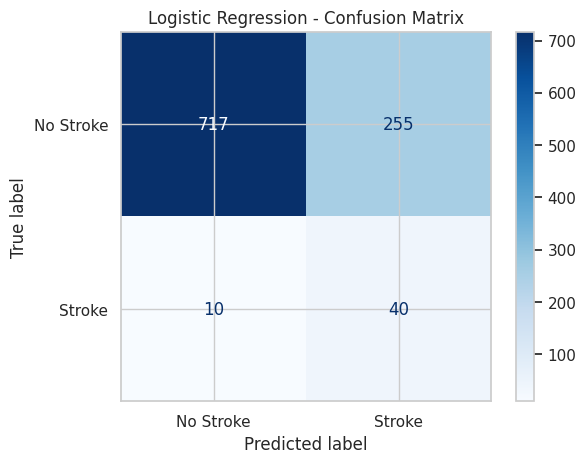


CART (Gini) - ROC-AUC: 0.755


CART (Gini) - classification report:
              precision    recall  f1-score   support

           0       0.98      0.73      0.84       972
           1       0.13      0.78      0.22        50

    accuracy                           0.73      1022
   macro avg       0.56      0.75      0.53      1022
weighted avg       0.94      0.73      0.81      1022



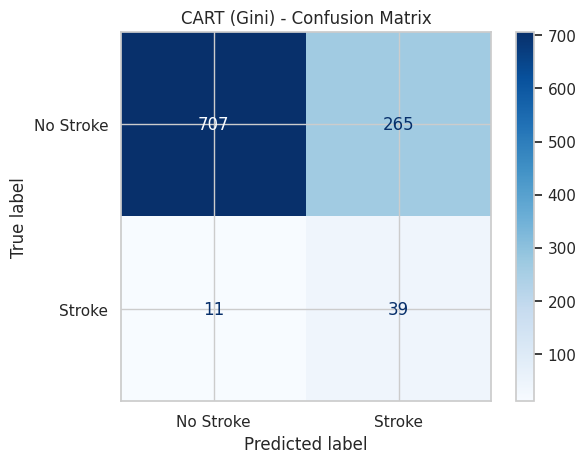

In [35]:
# Function to simulate the model results
def evaluate(model, name):
  y_pred = model.predict(X_test)
  y_proba = model.predict_proba(X_test)[:,1]
  roc_auc = roc_auc_score(y_test, y_proba)

  print(f"\n{name} - ROC-AUC: {roc_auc:0.3f}\n")
  print(f"\n{name} - classification report:")
  print(classification_report(y_test, y_pred))

  cm = confusion_matrix(y_test,y_pred)
  ConfusionMatrixDisplay(cm, display_labels=['No Stroke', 'Stroke']).plot(cmap='Blues', values_format='d')
  plt.title(f'{name} - Confusion Matrix')
  plt.show()

evaluate(best_logistic_reg, "Logistic Regression")
evaluate(best_cart, "CART (Gini)")

### **Results discussion**


Both the **Logistic Regression** and **CART (with Gini)** models were trained and optimized to detect whether a patient is at risk of having a stroke. Despite having a dataset that is highly imbalanced, the models demonstrated strong capabilities in several areas:

- **High recall for stroke (class 1)**:
  - **Recall** for the stroke class was 0.80 for Logistic Regression and 0.78 for CART (with Gini). This means the models were able to correctly identify 78-80% of true stroke cases.

  - Recall is one of the most important metrics, specifically because we would rather catch most true cases (even at some expense of false alarms) than risk missing actual stroke patients.

  - **Strong ROC-AUC scores**:
    - The ROC-AUC for Logistic Regression was 0.84, and for CART was 0.75.

    - This metric reflects how well the models distinguish between the classes, regardless of threshold. Considering the fact that the dataset was imbalanced, a score above 0.8 is generally considered very good

  - **There is precision trade-off**:
    - The **precision** for the stroke class is relatively low (between 0.13 and 0.14), that is because among the patients that are predicted as "at risk of stroke", many were false positives

    - While this may seem suboptimal, recall would still be prioritized over precision, because we don't want to avoid missing critical diagnoses

  - **Good Generalization**: The models generalize well across the test data, suggesting that preprocessing, SMOTE and hyperparameter tuning worked and were effective    

### **Feature Importance in Logistic Regression**

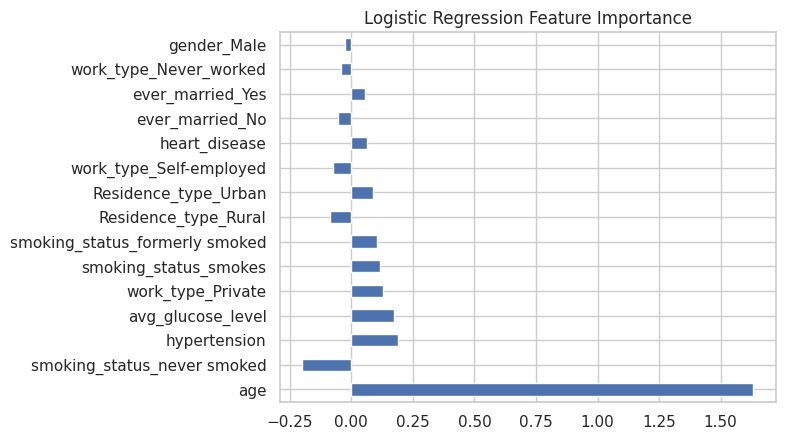

In [36]:
# Feature importance in Logistic Regression
logistic_reg = best_logistic_reg.named_steps['model']
ohe = best_logistic_reg.named_steps['prep'].named_transformers_['categorical']
feature_names = np.r_[num_cols, ohe.get_feature_names_out(categorical_cols)]
coef_df = (pd.Series(logistic_reg.coef_[0], index=feature_names)).sort_values(key=abs, ascending=False)
coef_df.head(15).plot.barh()
plt.title('Logistic Regression Feature Importance')
plt.show()

The coefficients in the logistic regression model represent the influence of each feature on the odds of the target class (stroke). A positive coefficient increases the likelihood of stroke, whereas a negative coefficient decreases it.

In the given graph we can see that the most impactful features were:
  - **Age**: is by far the most influential predictor. Older age strongly increases stroke risk, which aligns perfectly with medical literature

  - **Hypertension**: Patients with high blood pressure are at risk of experiencing a stroke as it damages blood vessel walls and makes them weaker.

  - **Average glucose levels**: Patients with elevated blood glucose are at higher risk of experiencing a stroke and it is expected because it is a well known stroke risk factor


   **What helps to prevent stroke according to the model:**
   
   - **Not smoking:** By far the best way to minimize the chances of experiencing a stroke is by not smoking. Smoking increases blood pressure and reduces oxygen in the blood, so patients who don't smoke might not suffer from increased blood pressure which was proven by the model to be a major risk factor

   - **Rural Residence** - Rural areas are usually less stressful and have cleaner air than urban areas. this may affect the health of patients and their chances of experiencing a stroke


  - **Self-employment:** Maybe because it has something to do with a particular lifestyle that helps patients keep themselves healthy or less stressed

### **CART Tree**

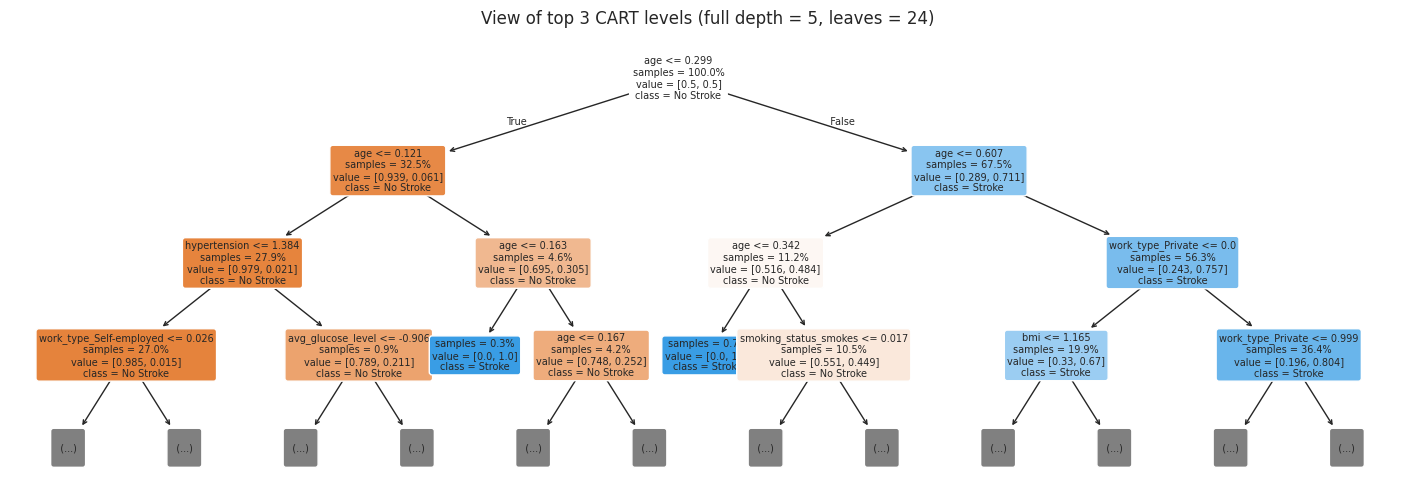

In [42]:
plt.figure(figsize=(18, 6))
plot_tree(
    best_cart.named_steps['model'],
    feature_names=feature_names,
    class_names=['No Stroke', 'Stroke'],
    filled=True,
    rounded=True,
    proportion=True,
    max_depth=3,      # Chosen for simplicity and better visualization
    fontsize=7,
    impurity=False
)
plt.title("View of top 3 CART levels (full depth = "
          f"{best_cart.named_steps['model'].get_depth()}, "
          f"leaves = {best_cart.named_steps['model'].get_n_leaves()})")
plt.show()

The **root node** separates the dataset into **younger vs. older patients** based on a standardised age threshold. Each branch then applies additional criteria to refine the classification (Orange nodes are majority No-stroke; blue nodes are majority Stroke, darker shades mean purer nodes)

- Observing the split hierarchy confirms that age is the most dominant risk factor for stroke, consistent with our logistic regression coefficients

- Among younger patients, the next most informative feature is hypertension. Hypertensive children or young adults, though rare, carry noticeably higher risk

- On the older side, `work_type = Private` emerges as the main discriminator. This hints late-career private-sector employment, or the socioeconomic factors it reflects, may be associated with additional risk

- Within that older-private subgroup, **BMI** and **smoking status** further partition risk, reinforcing known lifestyle contributors

**Take-away**: patients who are younger, non-hypertensive, and have balanced lifestyles (they have healthy BMI, non-smokers) lie on the safest path through the tree, whereas older private-sector workers with high BMI or current smoking habits are routed to the highest-risk leaves

##2.(e) **Comparative Review of Model Results and Suggestions**


| **Metric**              | **Logistic Regression**      | **CART (with Gini)**             |
|-------------------------|------------------------------|-----------------------------|
| **Accuracy**            | 0.74                         | 0.73                        |
| **Stroke Recall (1)**   | 0.80                         | 0.78                        |
| **Stroke Precision**    | 0.14                         | 0.13                        |
| **F1-Score (Stroke)**   | 0.23                         | 0.22                        |
| **ROC-AUC**             | **0.84**                    | 0.75                       |
| **Interpretability**    | Medium (feature weights)     | **High** (decision paths)   |
| **Handling Complexity** | Low (linear patterns)        | **High** (non-linear splits) |


We can see that:

  - **Logistic Regression** outperformed **CART** in terms of **ROC-AUC**, which suggests better probability separation between stroke and non-stroke cases.

  - Both models provide intuitive interpretability, however, **CART** offers higher transparency because its decision rules are explicit, whereas Logistic Regression shows only weight magnitudes

  - Both models capture **the most critical cases (seen in high recall)** but it was at the expense of lower precision, something that is reflected often in imbalanced datasets

**Which of the two models is better?**

It depends on what is our specific goal. If our goal is to have a reliable stroke detection model that achieves good results and is more stable, then we should choose **Logistic Regression**, as it has shown better **ROC-AUC** value and the **recall** for stroke is still quite strong.

However, if the goal is to have high explainability and logic transparency (for doctors or policy makers for instance), then choosing **CART** would be a better option because its decision tree shows explicit decision rules which will be useful, and the model by itself achieves similar recall for strokes.

**What are the stroke prevention suggestions we can offer patients?**

Based on the influential risk factors that the models provided, we can offer several suggestions:

1. Patients must maintain a **screening routine**, especially for older adults and hypertensive patients - as they are at higher risk of suffering from stroke

2. **Spreading more awareness on lifestyle changes** can help patients, especially older ones which are at higher risk, to have a better lifestyle - thus improving their health and lowering their chances of experiencing strokes. It begins with blood glucose monitoring, and avoiding eating too many sugary or starchy foods. Patients who smoke should be encouraged to stop smoking as it is a risk factor they should be aware of.   

**What are the suggestions for model improvement**

There are a few ways we can further enhance the performance and reliability of our models:

1. Use other, more advanced algorithms such as Gradient Boosted Trees (XGBOOST), which typically outperform single decision trees.

2. Address the class imbalance further by trying other ensemble balancing method (like under-sampling in addition to SMOTE)

3. Expand the dataset if possible, in order to gather more stroke cases or synthetic data to stabilize minority class prediction